# 实现图片二值化

## 检查Lena的图片 
我们首先导入OpenCV-Python库用作图像处理（Sobel），matplotlib库用作绘图。

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

我们可以通过`imread`方法读取jpg格式的图片，原图是一张400x400大小的三通道的图片。

In [3]:
img = cv2.imread("./lena.jpg")
print("原始图像尺寸：{}".format(img.shape))

原始图像尺寸：(400, 400, 3)


通过`imshow`方法进行图片显示。

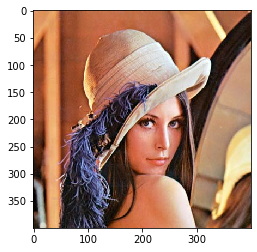

In [4]:
plt.imshow(img[:,:,::-1])

### RGB图转灰度图
将RGB图像转为灰度图，我们可以直观的看到数据维度的变化。

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("灰度图尺寸：{}".format(gray.shape))

灰度图尺寸：(400, 400)


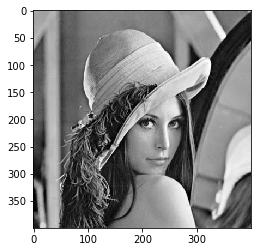

In [6]:
plt.imshow(gray,cmap='gray')

# 02:  Hardware 
## 直接调用
### 载入Overlay

将硬件设计部署到板卡上，根据图片尺寸分配内存，并将图像复制到对应位置。

In [7]:
from pynq import Overlay, allocate

overlay = Overlay("./binary.bit")

binary = overlay.binary_0

In [8]:
# allocate memory
rows, cols= gray.shape
input_buffer = allocate(shape=(rows*cols,), dtype='u1')
output_buffer = allocate(shape=(rows*cols,), dtype='u1')

# input
gray_new = np.uint8(gray)
np.copyto(input_buffer, gray_new.flatten())

### 写入参数

In [9]:
binary.write(0x10, rows)
binary.write(0x18, cols)

由于提供了`Sobel.hwh`文件，`sobel`对象已经包含了Register Map并将其暴露出来，我们可以直接打印查看各寄存器的信息：

In [10]:
binary.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0),
  rows = Register(rows=write-only),
  cols = Register(cols=write-only)
}

我们也可以直接在Register Map中与其交互，而不需要去手动输入对应的地址：

In [11]:
binary.register_map.rows = rows
binary.register_map.cols = cols

### 启动IP

将IP中的DMA对象提取出来。

In [12]:
dma = overlay.axi_dma_0

Binary IP 使用了AXI Stream的接口格式。
- 我们需要调用DMA读取输入缓冲，并将数据发送到AXI Stream Master
- 之后，DMA应从AXI Stream Slave中将结果写回到输出缓冲中
- `wait`语句确保了DMA的处理操作已经完成

In [13]:
import time

binary.register_map.CTRL.AP_START = 1

start_time = time.time()

dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)
dma.sendchannel.wait() # wait for send channel
dma.recvchannel.wait() # wait for recv channel

end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.013979434967041016s


将结果进行可视化。

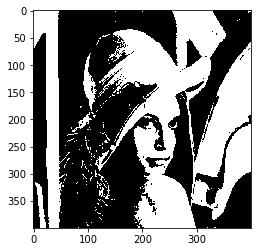

In [14]:
plt.imshow(output_buffer.reshape(rows, cols),cmap='gray')